# **Preparation**

``note: jalankan semua code ini & pastikan pakai GPU biar cepet``

## **Import Library**

In [ ]:
# Install
!pip install PyDOE
!pip install tensorflow==1.15

In [1]:
# Import
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import scipy.io
import tensorflow as tf
import time
import timeit
import math as m
import scipy.interpolate

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs


In [2]:
import matplotlib.pyplot as plt
import numpy as np

## **Class & Functions**

### **PINN Class**

In [38]:
class Pinn:

    def __init__(self, data, params, problem_type, exist_model=False, file_dir=""):
        # Initialize & Unpack Input data
        self.unpack(data, params)
        self.initialize_variables()
        self.problem_type = problem_type

        # Initialize Neural Network Computational Graph
        # Weight & biases
        if exist_model:
            print("Loading NN parameters ...")
            self.weights, self.biases = self.load_model(file_dir)
        else:
            self.weights, self.biases = self.initialize_network()

        # Placeholder & Graph
        # Placeholder (where we put input)
        self.initialize_placeholders()

        # Computational graph of Physics-Informed
        self.graph_network()

        # Computational graph of loss
        self.graph_loss()

        # Optimizers
        self.initialize_optimizers()

        # Session
        self.initialize_session()

    def callback_inverse(self, loss_test, loss_total, loss_collo, loss_meu, loss_init, lambda_1):
        self.count += 1
        self.loss_test_log.append(loss_test)
        self.loss_total_log.append(loss_total)
        self.loss_collo_log.append(loss_collo)
        self.loss_meu_log.append(loss_meu)
        self.loss_init_log.append(loss_init)
        self.lambda_1_log.append(lambda_1)

        if self.count % self.verboses_newton == 0:    
           print("iter: %d, Loss Test: %.4e, Loss Total: %.4e, Loss Collo: %.4e, Loss Measurement: %.4e, Loss Init: %.4e, lambda_1: %.3f" %
                 (self.count, loss_test, loss_total, loss_collo, loss_meu, loss_init, lambda_1[0]))
    
    def callback(self, loss_test, loss_total, loss_collo, loss_meu, loss_init):
        self.count += 1
        self.loss_test_log.append(loss_test)
        self.loss_total_log.append(loss_total)
        self.loss_collo_log.append(loss_collo)
        self.loss_meu_log.append(loss_meu)
        self.loss_init_log.append(loss_init)
        
        if self.count % self.verboses_newton == 0:    
           print("iter: %d, Loss Test: %.4e, Loss Total: %.4e, Loss Collo: %.4e, Loss Measurement: %.4e, Loss Init: %.4e" %
                 (self.count, loss_test, loss_total, loss_collo, loss_meu, loss_init))

    def normalize_input_data(self):
        # Normalize data
        x_c = self.normalize_data(data=self.x_c, axis="x")
        t_c = self.normalize_data(data=self.t_c, axis="t")
        x_meu = self.normalize_data(data=self.x_meu, axis="x")
        t_meu = self.normalize_data(data=self.t_meu, axis="t")
        x_initial = self.normalize_data(data=self.x_initial, axis="x")
        t_initial = self.normalize_data(data=self.t_initial, axis="t")
        x_test = self.normalize_data(data=self.x_test, axis="x")
        t_test = self.normalize_data(data=self.t_test, axis="t")

        return x_c, t_c, x_meu, t_meu, x_initial, t_initial, x_test, t_test

    def fit_newton(self):
        # Change flag
        self.newton_started = True
        self.count += 0

        # Normalize data
        (x_c, t_c,  
         x_meu, t_meu, 
         x_initial, t_initial, 
         x_test, t_test) = self.normalize_input_data()

        # Create dictionary
        tf_dict = {self.x_c_tf: x_c, self.t_c_tf: t_c,                              # collocation data
                   self.x_meu_tf: x_meu, self.t_meu_tf: t_meu,                      # measurement data
                   self.u_meu_tf: self.u_meu,
                   self.x_initial_tf: x_initial, self.t_initial_tf: t_initial,      # initial data
                   self.u_initial_tf: self.u_initial, 
                   self.x_test_tf: x_test, self.t_test_tf: t_test,                  # test data
                   self.u_test_tf:self.u_test}

        # Optimize
        if self.problem_type == "Inverse":
            self.train_op_newton.minimize(self.sess,
                                         feed_dict=tf_dict,
                                         fetches=[self.loss_test, self.loss_total, 
                                                 self.loss_collo, self.loss_meu, self.loss_initial,
                                                 self.lambda_1],
                                         loss_callback=self.callback_inverse)
        else:
            self.train_op_newton.minimize(self.sess,
                                          feed_dict=tf_dict,
                                          fetches=[self.loss_test, self.loss_total, 
                                                  self.loss_collo, self.loss_meu, self.loss_initial],
                                          loss_callback=self.callback)
            
    def graph_loss(self):
        # Test
        self.loss_test = tf.math.sqrt(tf.reduce_mean(tf.square(self.u_test_tf - self.u_test_pred))) 
        
        # Collocation points
        self.loss_collo = tf.reduce_mean(tf.square(self.f_pred_u)) 
        
        # Measurement points
        self.loss_meu = tf.reduce_mean(tf.square(self.u_meu_pred-self.u_meu_tf))
        
        # Initial conditions
        self.loss_initial = tf.reduce_mean(tf.square(self.u_initial_pred-self.u_initial_tf)) 
        
        # Total loss
        self.loss_total = self.loss_collo + self.loss_meu + self.loss_initial

    def graph_network(self):
        # Test data
        (self.u_test_pred) = self.net_dnn(self.x_test_tf, self.t_test_tf)
        
        # Predict data
        (self.u_pred) = self.net_dnn(self.x_tf, self.t_tf)

        # Physics Training
        # Collocation points
        (self.f_pred_u) = self.net_physics(self.x_c_tf, self.t_c_tf)

        # Measurement
        (self.u_meu_pred) = self.net_dnn(self.x_meu_tf, self.t_meu_tf)

        # Inlet
        (self.u_initial_pred) = self.net_dnn(self.x_initial_tf, self.t_initial_tf)

    def load_model(self, file_dir):
        weights = []
        biases = []
        num_layers = len(self.layers)
        
        with open(file_dir, 'rb') as f:
            dnn_weights, dnn_biases = pickle.load(f)

            # stored model mush has the same layers
            assert num_layers == (len(dnn_weights)+1)

            for num in range(0, num_layers-1):
                W = tf.Variable(dnn_weights[num])
                b = tf.Variable(dnn_biases[num])
                weights.append(W)
                biases.append(b)
                print('Loaded NN parameters successfully ...')

        return weights, biases

    def initialize_network(self):
        # Initialize
        weights = []
        biases = []
        num_layers = len(self.layers)

        # Create network
        for lyr in range(num_layers-1):
            # initialize weights from Xavier initialization
            np.random.seed(self.random_seed)
            W = self.xavier_init(size=[self.layers[lyr], 
                                       self.layers[lyr+1]])

            # initialize biases = 0
            np.random.seed(self.random_seed)
            b = tf.Variable(tf.zeros([1, self.layers[lyr+1]],
                                     dtype=tf.float32),
                            dtype=tf.float32)

            # Append generated weights & biases to the list
            weights.append(W)
            biases.append(b)

        return weights, biases

    def initialize_optimizers(self):
        if self.problem_type == "Inverse":
            variable_list = self.weights+self.biases+self.lambda_1
        else:
            variable_list = self.weights+self.biases
        
        self.train_op_newton = tf.contrib.opt.ScipyOptimizerInterface(
                                    self.loss_total,
                                    var_list = variable_list,
                                    method = "L-BFGS-B",
                                    options = {"maxiter": 100000,
                                               "maxfun": 100000,
                                               "maxcor": 50,
                                               "maxls": 50,
                                               "ftol": 1*np.finfo(float).eps})

    def initialize_placeholders(self):
        # Test data
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, self.x_test.shape[1]])
        self.t_test_tf = tf.placeholder(tf.float32, shape=[None, self.t_test.shape[1]])
        self.u_test_tf = tf.placeholder(tf.float32, shape=[None, self.u_test.shape[1]])
        
        # Predict data
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])

        # Collocation data
        self.x_c_tf = tf.placeholder(tf.float32, shape=[None, self.x_c.shape[1]])
        self.t_c_tf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])

        # Measurement data
        self.x_meu_tf = tf.placeholder(tf.float32, shape=[None, self.x_meu.shape[1]])
        self.t_meu_tf = tf.placeholder(tf.float32, shape=[None, self.t_meu.shape[1]])
        self.u_meu_tf = tf.placeholder(tf.float32, shape=[None, self.u_meu.shape[1]])

        # Wall
        self.x_initial_tf = tf.placeholder(tf.float32, shape=[None, self.x_initial.shape[1]])
        self.t_initial_tf = tf.placeholder(tf.float32, shape=[None, self.t_initial.shape[1]])
        self.u_initial_tf = tf.placeholder(tf.float32, shape=[None, self.u_initial.shape[1]])

    def initialize_session(self):
        tf_config = tf.ConfigProto(allow_soft_placement=True,
                                   log_device_placement=True)
        self.sess = tf.Session(config=tf_config)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_variables(self):
        # For saving loss
        self.loss_total_log = []
        self.loss_collo_log = []
        self.loss_meu_log = []
        self.loss_init_log  = []
        self.loss_test_log = []
        self.count = 0
        self.newton_started = False
        self.lambda_1 = [tf.Variable([0.5], dtype=tf.float32)]
        self.lambda_1_log = []

    def net_dnn(self, x, t):
        # Find results
        X = tf.concat([x, t], 1)
        results = self.net_forward(X)
        
        return results        

    def net_forward(self, X):
        num_layers = len(self.weights)+1
        H = X

        for lyr in range(num_layers-2):
            W = self.weights[lyr]
            b = self.biases[lyr]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)

        return Y

    def net_physics(self, x, t):
        # Find results from DNN
        T = self.net_dnn(x, t)

        # Temperature gradient
        T_x = tf.gradients(T, x)[0] / self.sigma_x
        T_xx = tf.gradients(T_x, x)[0] / self.sigma_x
        T_t = tf.gradients(T, t)[0] / self.sigma_t
        
        x = x*self.sigma_x + self.mu_x
        t = t*self.sigma_t + self.mu_t
        
        # Physics error
        if self.problem_type == "Inverse":
            lambda_1 = self.lambda_1
            f = lambda_1*T_t - T_xx - tf.exp(x + 2*t)
        else:
            f = T_t - T_xx - tf.exp(x + 2*t)

        return f
    
    def normalize_data(self, data, axis):
        if axis == "x":
            normalized_data = (data - self.mu_x) / self.sigma_x
        elif axis == "t":
            normalized_data = (data - self.mu_t) / self.sigma_t

        return normalized_data

    def predict(self, x_star, t_star):
        # Prepare the input
        x_star = (x_star - self.mu_x) / self.sigma_x
        t_star = (t_star - self.mu_t) / self.sigma_t

        # Create dictionary
        tf_dict = {self.x_tf:x_star, self.t_tf:t_star}

        # Predict
        u_star = self.sess.run(self.u_pred, tf_dict)

        return u_star

    def save_loss(self, file_dir):
        loss_test = np.array(self.loss_test_log)
        loss_data = np.column_stack((self.loss_total_log, 
                                     self.loss_collo_log,
                                     self.loss_bound_log,
                                     self.loss_init_log,
                                     loss_test))
        loss_df = pd.DataFrame(loss_data, columns=["total", "collo", "measurement", "initial", "error_u"])
        joblib.dump(loss_df, file_dir)

    def save_model(self, file_dir):
        weights = self.sess.run(self.weights)
        biases = self.sess.run(self.biases)

        with open(file_dir, 'wb') as f:
            pickle.dump([weights, biases], f)
            print("Save NN parameters successfully...")

    def unpack(self, data, params):
        # Initialize
        self.data = data
        self.params = params

        # Unpack Parameters
        # Data-Boundary
        self.lb = params["data"]["lb"]
        self.ub = params["data"]["ub"]
        
        self.random_seed = data["train"]["random_seed"]
        
        # Data-Collocation
        self.x_c = data["train"]["collo"][:, 0:1]
        self.t_c = data["train"]["collo"][:, 1:2]
        self.mu_x = data["train"]["mu_x"]
        self.mu_t = data["train"]["mu_t"]
        self.sigma_x = data["train"]["sigma_x"]
        self.sigma_t = data["train"]["sigma_t"]
        
        # Measurements
        self.loc_num = params["data"]["loc"]
        self.meu_num = params["data"]["meu"]
        meu = data["train"]["mea"]
        self.x_meu = meu[:, 0:1]
        self.t_meu = meu[:, 1:2]
        self.u_meu = meu[:, 2:3]
        
        # Data-Wall
        self.x_initial = data["train"]["wall"][:, 0:1]
        self.t_initial = data["train"]["wall"][:, 1:2]
        self.u_initial = data["train"]["wall"][:, 2:3]

        # Data-Test
        self.x_test = data["test"][:, 0:1]
        self.t_test = data["test"][:, 1:2]
        self.u_test = data["test"][:, 2:3]
        
        # Network
        self.layers = params["network"]["layers"]
        self.verboses_newton = params["network"]["verboses_newton"]

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))

        # tf.set_random_seed(20)
        np.random.seed(self.random_seed)
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], 
                                               stddev=xavier_stddev, 
                                               dtype=tf.float32,
                                               seed=self.random_seed), 
                           dtype=tf.float32)


### **Cases**

In [39]:
class Conduction:

    def __init__(self, add_noise=False, save_fig=False):
        self.add_noise = add_noise
        self.save_fig = save_fig
        self.data = {}

    # def analytics_solution(self, y):
    def analytics_solution(self, x, t):
        T_ = np.exp(x+2*t)

        return T_

    def generate_bc(self, loc, n):
        x = loc*self.ub[0]*np.ones((n,1))
        np.random.seed(self.random_seed)  
        t = lhs(1,n)*self.ub[1]
        T = self.analytics_solution(x, t)

        # concat data
        bc_datas = np.concatenate((x, t, T), axis=1)
        
        return bc_datas

    def generate_ic(self):
        n = self.n_wall
        np.random.seed(self.random_seed)      
        x = lhs(1,n)*self.ub[0]
        t = 0.0*lhs(1,n)
        T = self.analytics_solution(x, t)

        # concat data
        ic_datas = np.concatenate((x, t, T), axis=1)
        
        return ic_datas 
        
    
    def generate_collo(self):
        # unpack
        n = self.n_collo
        lb = self.lb
        ub = self.ub

        # create points
        np.random.seed(self.random_seed)
        collo_pts = lb + (ub-lb)*lhs(2, n, criterion=None)

        self.mu_X, self.sigma_X = collo_pts.mean(0), collo_pts.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]
        self.mu_t, self.sigma_t = self.mu_X[1], self.sigma_X[1]
                
        return collo_pts 

    def generate_train_data(self, param):
        
        # Unpack parameters
        self.unpack(param)

        # Generate points
        # Generate boundary conditions data 
        init_cond = self.generate_ic()
        
        loc = self.loc_num   # location measurements --> e.g 0%, 50%, 100%
        meu = self.meu_num   # Measurements --> 50, 100, 150..
        
        bc = []
        
        self.data["train"] = {}
        for i in range (0, len(loc)):
            mea = self.generate_bc(loc[i],int(meu[i]))
            bc.append(mea)
            self.data["train"][f"loc={loc[i]}"] = bc[i]
            
        mea = np.zeros(shape=(1, 3))
        for i in range(0, len(self.loc_num) ):
            mea = np.concatenate((mea, self.data["train"][f"loc={self.loc_num[i]}"]), axis=0)
            
        mea = mea[1:,:]
        T = mea[:, 2:3]
        T_init = init_cond[:,2:3]
        self.T = T
        self.T_init= T_init
            
        # noise addition
        if self.add_noise:
            noise = self.noise_level
            maxT = max([np.max(T), np.max(T_init)])
            sigma = noise * maxT
            print(f"T max: {maxT}")
            np.random.seed(self.random_seed)
            random_noise_T = sigma*np.random.randn(T.shape[0],1)
            
            T = T + random_noise_T
            
            random_noise_init = sigma*np.random.randn(T_init.shape[0], 1)
            
            T_init = T_init + random_noise_init
            
        self.random_noise_T = random_noise_T
        self.random_noise_init = random_noise_init
            
        self.data["train"]["mea"] = np.concatenate((mea[:, 0:2], T), axis=1)         
        self.data["train"]["wall"] = np.concatenate((init_cond[:, 0:2], T_init), axis=1)
            

        # Generate collocations points data
        collo_ = self.generate_collo()

        # Pack data
        self.data["train"]["collo"] = collo_
        self.data["train"]["mu_x"] = self.mu_x
        self.data["train"]["sigma_x"] = self.sigma_x
        self.data["train"]["mu_t"] = self.mu_t
        self.data["train"]["sigma_t"] = self.sigma_t
        self.data["train"]["random_seed"] = self.random_seed

    def generate_test_data(self, param):
        # Unpack parameters
        self.unpack(param)

        # Generate points
        length_ = self.ub - self.lb
        min_length_ = np.argmin(length_)
        frac_ = max(length_) / min(length_)
        n_test_1 = int(frac_ * self.n_test)

        # Create grid
        if min_length_ == 0:
            self.n_x = self.n_test
            self.n_y = n_test_1
        else:
            self.n_x = n_test_1
            self.n_y = self.n_test
        x_ = np.linspace(self.lb[0], self.ub[0], num=(self.n_x)) 
        y_ = np.linspace(self.lb[1], self.ub[1], num=int(self.n_y/self.n_test))
        X, Y = np.meshgrid(x_, y_)
        X_flat = X.flatten()[:,None]
        Y_flat = Y.flatten()[:,None]
        T_ = self.analytics_solution(X_flat, Y_flat)

        self.data["test"] = np.column_stack((X_flat, Y_flat, T_))

    def plot(self):
        # unpack data
        collo_ = self.data["train"]["collo"]
        meu = []
        
        for i in range(0, len(self.loc_num)):
            meu.append(self.data["train"][f"loc={self.loc_num[i]}"])
        wall_ = self.data["train"]["wall"]

        # PLOT: points distribution
        # Properties
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        # Plot
        fig_w = 5
        fig_h = 5
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), constrained_layout=True, dpi=300)

        ax.plot([self.lb[0], self.ub[0]], [self.lb[1], self.lb[1]], 'k')
        ax.plot([self.lb[0], self.ub[0]], [self.ub[1], self.ub[1]], 'k')
        ax.plot([self.lb[0], self.lb[0]], [self.ub[1], self.lb[1]], 'k')
        ax.plot([self.ub[0], self.ub[0]], [self.ub[1], self.lb[1]], 'k')

        ax.scatter(collo_[:,0:1], collo_[:,1:2], marker='.', alpha=0.7, c='grey', label='Collo')
        for i in range(0, len(self.loc_num)):
            ax.scatter(meu[i][:,0:1], meu[i][:,1:2], marker='.', alpha=0.7,  label=f'Measurements, $x/L$={np.round(self.loc_num[i],2)}')
        ax.scatter(wall_[:,0:1], wall_[:,1:2], marker='.', alpha=0.7, c='b', label='IC')

        ax.set_title("Points distribution", fontsize=15)
        ax.set_xlabel("$x$ (m)", fontsize=20)
        ax.set_ylabel("$t$ (s)", fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.legend(fontsize=10, loc=4)
        ax.grid(linestyle="--")
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])

        if self.save_fig:
            fig.savefig("fig_point_distribution.eps", format="eps")
        plt.show()

    def unpack(self, param):
        # Bound
        self.lb = param["data"]["lb"]
        self.ub = param["data"]["ub"]

        # Discretizations
        self.n_collo = param["data"]["n_collo"]
        self.n_wall = param["data"]["n_wall"]
        self.n_test = param["data"]["n_test"]
        self.random_seed = param["data"]["seed"]
        self.noise_level = param["data"]["noise"]
        self.loc_num = param["data"]["loc"]
        self.meu_num = param["data"]["meu"]


### **Post Processing**

In [40]:
class PostProcessing:

    def __init__(self, model, params, save_fig=False):
        self.save_fig = save_fig
        self.unpack(model, params)

    def calculate_pinn(self):
        self.u_pinn = self.model.predict(self.X_flat, self.T_flat)
        self.x_pinn_ = self.X_flat.reshape(self.n_t, self.n_x)
        self.t_pinn_ = self.T_flat.reshape(self.n_t, self.n_x)
        self.u_pinn_ = self.u_pinn.reshape(self.n_t, self.n_x)

    def calculate_error(self, n_data):
        # X & T
        x_test = self.model.x_test 
        t_test = self.model.t_test

        # Prediction
        u_pinn = self.u_pinn

        u_analytic = np.exp(self.X_flat+2*self.T_flat)
        u_test = u_analytic
        self.u_test = u_test

        delta_u = np.abs(u_pinn - u_test)
        self.abs_err_u = np.sum(delta_u)/(self.n_x * self.n_t)

        rel_err_u_ij = delta_u/u_test
        self.rel_err_u = np.sum(rel_err_u_ij)/(self.n_x * self.n_t)
        
        lambda_ = self.model.lambda_1_log[-1][0][0]
        
        self.rel_err_lambda = np.abs(lambda_ - 1.0) / 1.0
                
        print(f"- Relative Error Lambda (%): {self.rel_err_lambda*100:5f}")
        print(f"- Absolute Error: {self.abs_err_u:5f}")
        print(f"- Relative Error (%): {self.rel_err_u*100:5f}")
        

        return x_test, t_test, u_pinn, u_test

    def create_test_data(self):
        # Find fraction
        length_ = self.ub - self.lb
        min_length_ = np.argmin(length_)
        frac_ = max(length_) / min(length_)
        n_test_1 = int(frac_ * self.n_test)

        # Create grid
        if min_length_ == 0:
            self.n_x = self.n_test
            self.n_t = n_test_1
        else:
            self.n_x = n_test_1
            self.n_t = self.n_test

        self.x = np.linspace(self.lb[0], self.ub[0], num=self.n_x)
        self.t = np.linspace(self.lb[1], self.ub[1], num=self.n_t)
        self.X, self.T = np.meshgrid(self.x, self.t)
        self.X_flat = self.X.flatten()[:, None]
        self.T_flat = self.T.flatten()[:, None]

    def display_loss(self):
        # SET
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        # Extract data
        loss_total = np.sqrt(self.model.loss_total_log)
        loss_collo = np.sqrt(self.model.loss_collo_log)
        loss_meu = np.sqrt(self.model.loss_meu_log)
        loss_init = np.sqrt(self.model.loss_init_log)
        loss_test = self.model.loss_test_log

        # Status
        if self.model.newton_started:
            run_status = "newton"
        else:
            run_status = "none"

        # Prepare
        iter_total = []

        if run_status == "newton":
            n_total = len(loss_total)

            for i in range(n_total):
                iter_total.append(i)
        else:
            n_total = 0
        
        # PLOT History
        if run_status != "none":
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), constrained_layout=True, dpi=300)
            ax.plot(iter_total, loss_total, "r", linestyle="solid", label="Physical Loss")
            ax.plot(iter_total, loss_collo, "g", linestyle="dashdot", label="Collocation Loss")
            ax.plot(iter_total, loss_meu, "b", linestyle="dotted", label="Measurement Loss")
            ax.plot(iter_total, loss_init, 'purple',linestyle='solid', label='Initial Loss')
            ax.plot(iter_total, loss_test, "black", linestyle="dashed", label="Test Error")

            ax.set_xlim(0, iter_total[-1])
            ax.set_yscale("log")
            ax.set_xlabel("Iterations", fontsize=12)
            ax.set_ylabel("RMSE", fontsize=12)
            ax.grid(linestyle="--")
            ax.legend(fontsize=10)
            ax.set_title('Loss History (Log Scale)', fontsize=17)
            ax.tick_params(axis='both', which='major', labelsize=10)

            # save figure
            if self.save_fig:
                fig.savefig("fig_loss_history.eps", format="eps")
            plt.show()
        
        print(f"- Last Iterations: {iter_total[-1]}")
        
    def display_contour(self):
        # FIND: PINN results
        self.create_test_data()
        self.calculate_pinn()

        # PLOT CONTOUR
        fig_h = 3 
        fig_w = 10

        # CALCULATE: error
        x_, t_, u_pinn, u_test = self.calculate_error(n_data = self.n_test)
        # PLOT: comparison
        self.plot_comparison(x=self.x, t=self.t, 
                            phi_pinn=u_pinn.reshape(self.n_t, self.n_x), 
                            phi_analytics=u_test.reshape(self.n_t, self.n_x), 
                            fig_w=fig_w, fig_h=fig_h*2)
        self.plot_comparison2(x=self.x, t=self.t, 
                             phi_pinn=u_pinn.reshape(self.n_t, self.n_x), 
                             phi_analytics=u_test.reshape(self.n_t, self.n_x), 
                             fig_w=fig_w, fig_h=fig_h*2)
        v_max = max(u_test)
        v_min = 0.0

        # PLOT: u_velocity
        
        self.plot_countour(x=self.X, t=self.T, 
                           x_flat=self.X_flat, t_flat=self.T_flat,
                           phi=self.u_pinn, phi_=self.u_pinn_, 
                           vmin=v_min, vmax=v_max,
                           types="T", 
                           fig_w=fig_w, fig_h=fig_h)

    def plot_comparison(self, x, t, phi_pinn, phi_analytics, fig_w, fig_h):
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(fig_w, fig_h), dpi=100, constrained_layout=False)
        
        # print(phi_pinn)
        ax[1].plot(t, phi_pinn[:,self.n_x//2].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[1].plot(t, phi_analytics[:,self.n_x//2], '--r', label="Analytical solution", linewidth=4)
        

        x_lim_min = min(np.min(phi_pinn), np.min(phi_analytics))
        x_lim_max = max(np.max(phi_pinn), np.max(phi_analytics))
        x_lim_min = 0
        x_lim_max = x_lim_max + 0.2*abs(x_lim_max)
        ax[1].set_ylim(x_lim_min, x_lim_max)
        ax[1].set_xlim(self.lb[1], self.ub[1])
        ax[1].set_xlabel("$t$ (s), $x=0.5$ m", fontsize=15)
        ax[1].set_ylabel("$T$ (\u2103)", fontsize=15)
        ax[1].grid(linestyle="--")
        ax[1].legend(fontsize=10)
        ax[1].set_title("Temperature comparison", fontsize=20)
        ax[1].tick_params(axis='both', which='major', labelsize=16)

        ax[0].plot(t, phi_pinn[:,self.n_x//4].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[0].plot(t, phi_analytics[:,self.n_x//4], '--r', label="Analytical solution", linewidth=4)
        ax[0].set_ylim(x_lim_min, x_lim_max)
        ax[0].set_xlim(self.lb[1], self.ub[1])
        ax[0].set_xlabel("$t$ (s), $x=0.25$ m", fontsize=15)
        ax[0].set_ylabel("$T$ (\u2103)", fontsize=15)
        ax[0].grid(linestyle="--")
        ax[0].legend(fontsize=10)
        ax[0].tick_params(axis='both', which='major', labelsize=16)

        ax[2].plot(t, phi_pinn[:,self.n_x//4*3+1].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[2].plot(t, phi_analytics[:,self.n_x//4*3+1], '--r', label="Analytical solution", linewidth=4)
        
        ax[2].set_ylim(x_lim_min, x_lim_max)
        ax[2].set_xlim(self.lb[1], self.ub[1])
        ax[2].set_xlabel("$t$ (s), $x=0.75$ m", fontsize=15)
        ax[2].set_ylabel("$T$ (\u2103)", fontsize=15)
        ax[2].grid(linestyle="--")
        ax[2].legend(fontsize=10)
        ax[2].tick_params(axis='both', which='major', labelsize=16)
        plt.tight_layout()

    def plot_comparison2(self, x, t, phi_pinn, phi_analytics, fig_w, fig_h):
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(fig_w, fig_h), dpi=100, constrained_layout=False)
        
        # print(phi_pinn)
        ax[1].plot(x, phi_pinn[self.n_x//2,:].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[1].plot(x, phi_analytics[self.n_x//2,:], '--r', label="Analytical solution", linewidth=4)
        

        x_lim_min = min(np.min(phi_pinn), np.min(phi_analytics))
        x_lim_max = max(np.max(phi_pinn), np.max(phi_analytics))
        x_lim_min = 0
        x_lim_max = x_lim_max + 0.2*abs(x_lim_max)
        ax[1].set_ylim(x_lim_min, x_lim_max)
        ax[1].set_xlim(self.lb[1], self.ub[1])
        ax[1].set_xlabel("$x$ (m), $t=0.5$ s ", fontsize=18)
        ax[1].set_ylabel("$T$ (\u2103)", fontsize=18)
        ax[1].grid(linestyle="--")
        ax[1].legend(fontsize=10)
        ax[1].set_title("Temperature comparison", fontsize=25)
        ax[1].tick_params(axis='both', which='major', labelsize=19)

        ax[0].plot(x, phi_pinn[self.n_x//4,:].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[0].plot(x, phi_analytics[self.n_x//4,:], '--r', label="Analytical solution", linewidth=4)
        
        ax[0].set_ylim(x_lim_min, x_lim_max)
        ax[0].set_xlim(self.lb[1], self.ub[1])
        ax[0].set_xlabel("$x$ (m), $t=0.25$ s ", fontsize=18)
        ax[0].set_ylabel("$T$ (\u2103)", fontsize=18)
        ax[0].grid(linestyle="--")
        ax[0].legend(fontsize=10)
        ax[0].tick_params(axis='both', which='major', labelsize=19)

        ax[2].plot(x, phi_pinn[self.n_x//4*3+1,:].flatten(), 'b', label="PINN solution", linewidth=4)
        ax[2].plot(x, phi_analytics[self.n_x//4*3+1,:], '--r', label="Analytical solution", linewidth=4)
        
        ax[2].set_ylim(x_lim_min, x_lim_max)
        ax[2].set_xlim(self.lb[1], self.ub[1])
        ax[2].set_xlabel("$x$ (m), $t=0.75$ s ", fontsize=18)
        ax[2].set_ylabel("$T$ (\u2103)", fontsize=18)
        ax[2].grid(linestyle="--")
        ax[2].legend(fontsize=10)
        ax[2].tick_params(axis='both', which='major', labelsize=19)
        plt.tight_layout()
        
    def plot_countour(self, x, t, x_flat, t_flat, phi, phi_, vmin, vmax, types, fig_w, fig_h):
        # Set
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        # Create plot
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=300, constrained_layout=False)

        # Unpack
        cf = ax.scatter(x_flat, t_flat, c=phi, 
                        alpha=1., edgecolors='none', cmap='jet', marker=".", s=50, vmin=vmin, vmax=vmax)
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])
        
        ax.set_title(f'${types} (x,t)$ PINN Solution', fontsize=20)
        
        ax.set_xlabel('$x$ (m)', fontsize=20)
        ax.set_ylabel('$t$ (s)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.contour(x, t, phi_, colors='k', linewidths=0.2, levels=50)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cb = fig.colorbar(cf, cax=cax)
        cb.ax.set_title('$T$(\u2103)', fontsize=18)
        ticks = np.linspace(vmin, vmax, 3)
        ticks = np.floor(ticks)
        cb.set_ticks(ticks)
        cb.ax.tick_params(labelsize=16)

        # Analytical Solution contour
        T = np.exp(x_flat+2*t_flat)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=300, constrained_layout=False)
        cf = ax.scatter(x_flat, t_flat, c=T, alpha=1., edgecolors='none', cmap='jet', marker=".", s=50, vmin=vmin, vmax=vmax)
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])

        ax.set_title(f'${types} (x,t)$ Analytical Solution', fontsize=20)

        ax.set_xlabel('$x$ (m)', fontsize=20)
        ax.set_ylabel('$t$ (s)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.contour(x, t, np.exp(x + 2*t), colors='k', linewidths=0.2, levels=50)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        cb = fig.colorbar(cf, cax=cax)
        cb.ax.set_title('$T$(\u2103)', fontsize=18)
        ticks = np.linspace(vmin, vmax, 3)
        ticks = np.floor(ticks)
        cb.set_ticks(ticks)
        cb.ax.tick_params(labelsize=16)

        # save figure
        if self.save_fig:
            fig.savefig(f"fig_{types}.eps", format="eps")
        plt.show()

    def unpack(self, model, params):
        self.model = model
        self.params = params

        self.lb = params["data"]["lb"]
        self.ub = params["data"]["ub"]
        self.n_test = params["data"]["n_test"]
        self.verboses_newton = params["network"]["verboses_newton"]

# **RUN**

In [41]:
# Set GPU to tensorflow session
with tf.device('/device:GPU:2'):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # session = tf.InteractiveSession(config=config)
    session = tf.Session(config=config)

## **Parameter**

In [42]:
def generate_param():
    params = {}

    params["data"] = {}
    params["data"]["lb"] = np.array([0., 0.])
    params["data"]["ub"] = np.array([1.0, 1.0])
    params["data"]["n_collo"] = 1000
    params["data"]["n_test"] = 201
    params["data"]["seed"] = 543212
    n = 101
    params["data"]["n_wall"] = n
    loc_num = 3
    params["data"]["loc"] = np.linspace(0, 1, loc_num) #in %
    params["data"]["meu"] = [n]*loc_num    

    params["physic"] = {}

    params["network"] = {}
    params["network"]["verboses_newton"] = 100

    return params


##### **Generate Parameters**

T max: 19.69898198656043


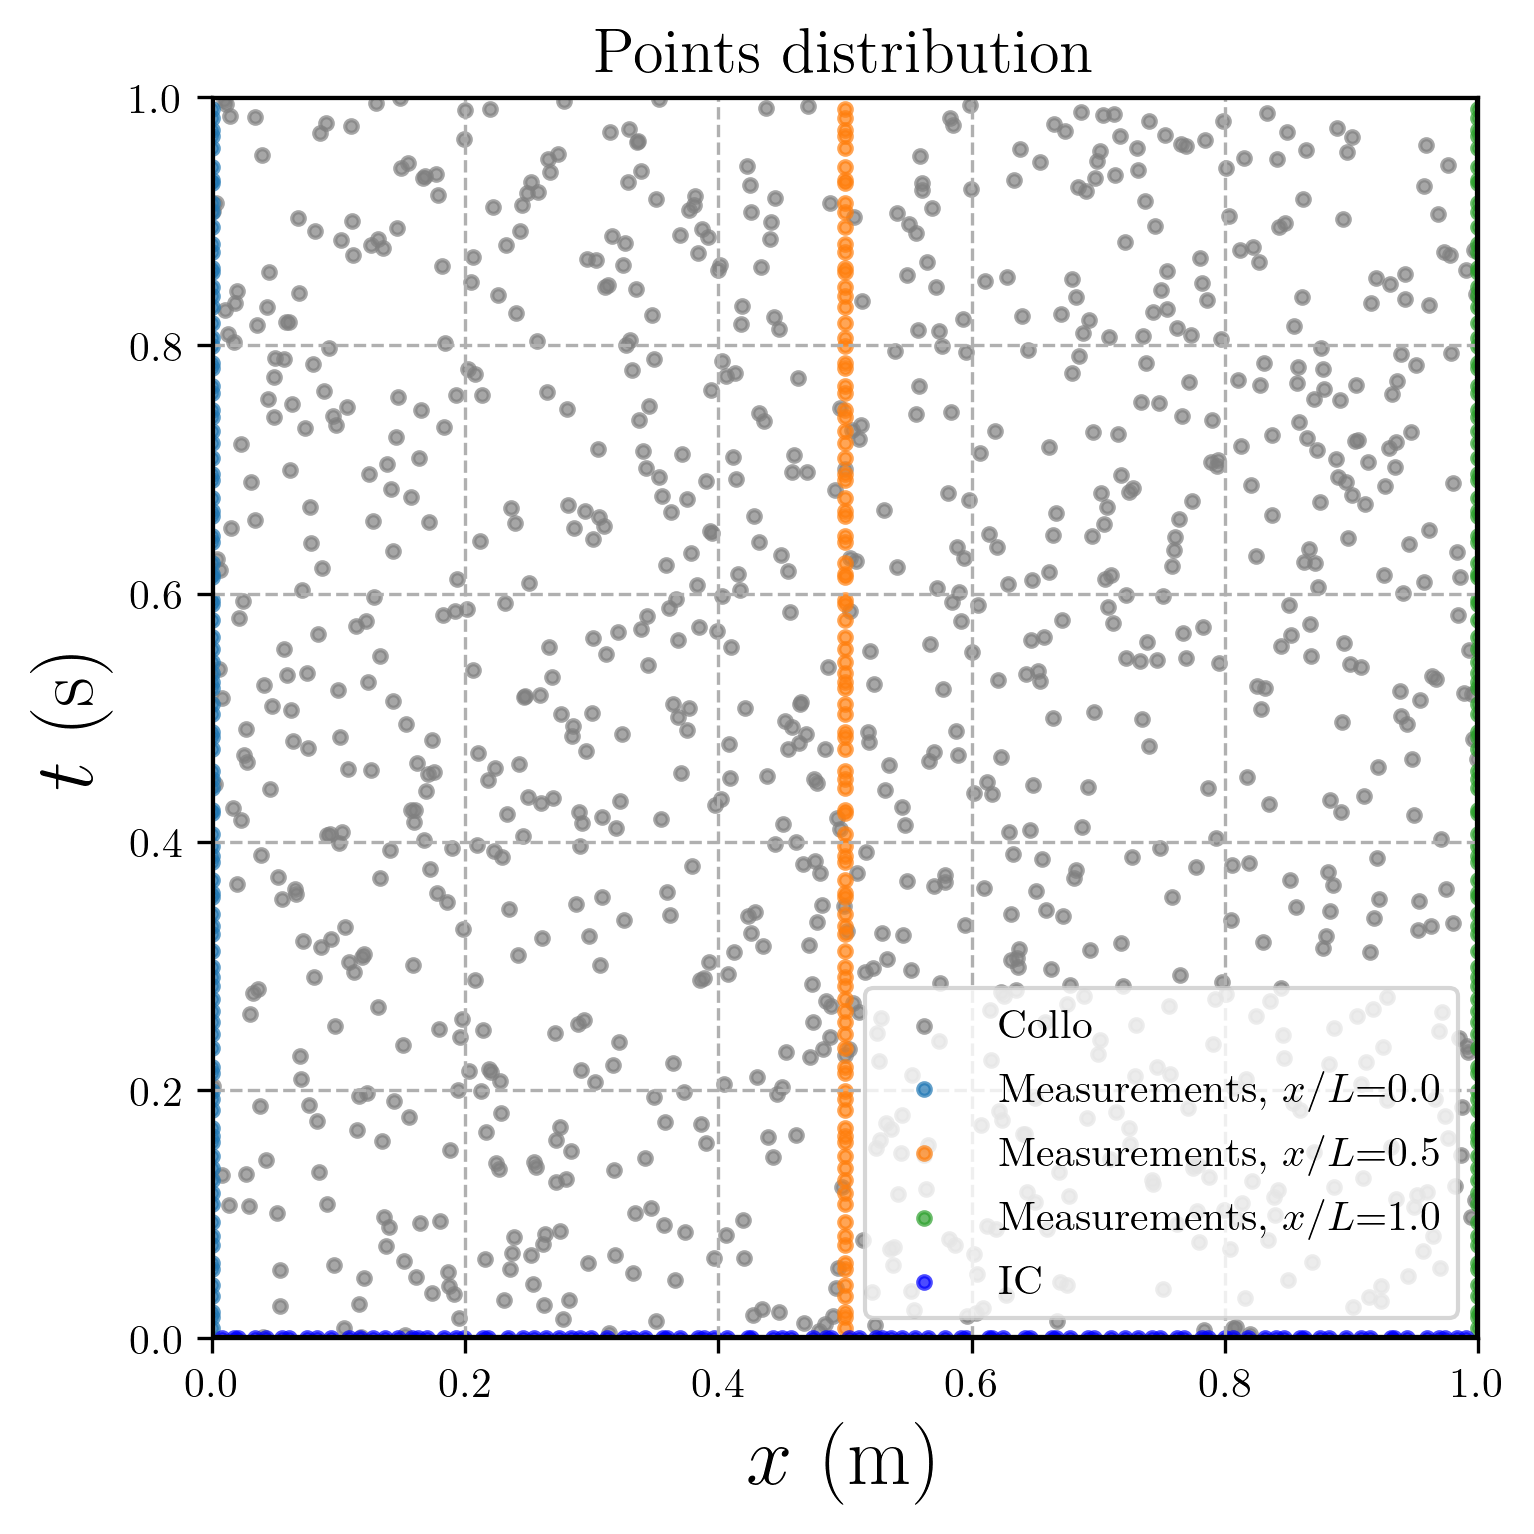

In [49]:
prob = 'Inverse'
# prob = "direct"
params = generate_param()

params["network"]["layers"] = [2] + 2*[5] + [1]
params["data"]["noise"] = 0.03

case = Conduction(add_noise=True)
case.generate_train_data(param=params)
case.generate_test_data(param=params)
case.plot()

##### **Heat Generation Plot**

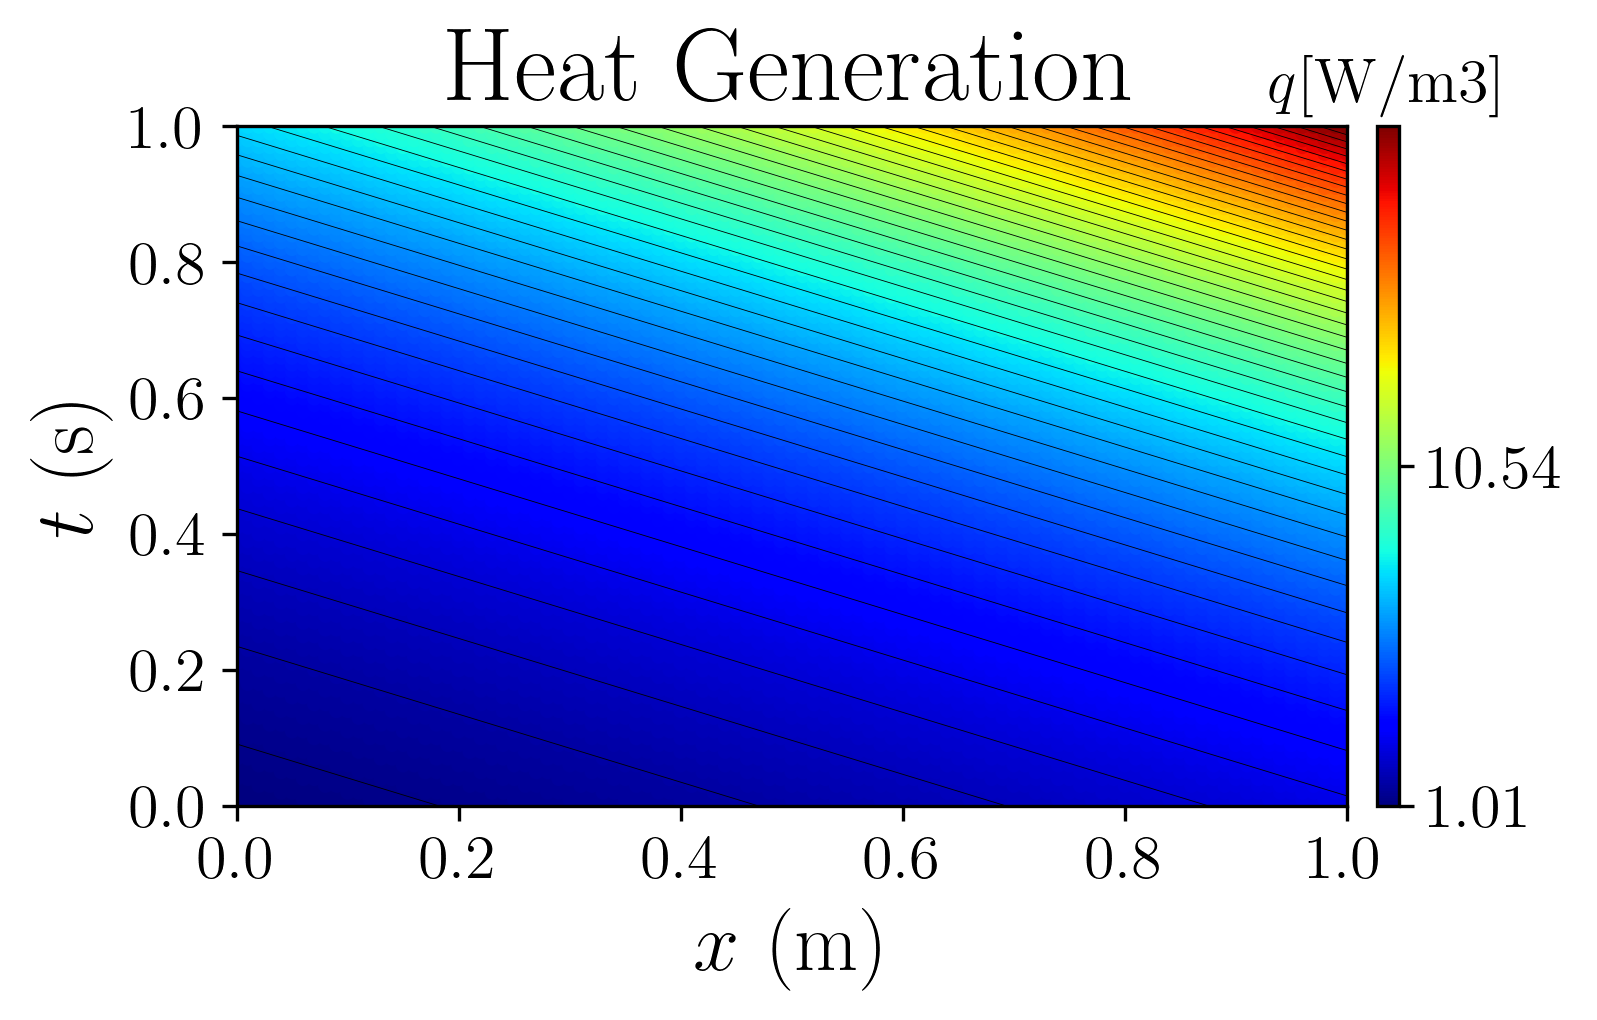

In [50]:
x = np.linspace(0,1,101)
y = np.linspace(0,1,101)

X,Y = np.meshgrid(x,y)
x_flat = X.flatten()[:,None]
y_flat = Y.flatten()[:,None]

x = x_flat
t = y_flat
h = np.exp(x + 2*t)

fig_h = 3
fig_w = 5

vmin=min(h)
vmax=max(h)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_w, fig_h), dpi=300, constrained_layout=False)

cf = ax.scatter(x_flat, y_flat, c=h, 
                alpha=1., edgecolors='none', cmap='jet', marker=".", s=50, vmin=vmin, vmax=vmax)

ax.set_title(f'Heat Generation', fontsize=25)

ax.set_xlabel('$x$ (m)', fontsize=20)
ax.set_ylabel('$t$ (s)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.contour(X, Y, h.reshape(101,101), colors='k', linewidths=0.2, levels=50)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cb = fig.colorbar(cf, cax=cax)
ticks = np.linspace(vmin, vmax, 3)
ticks = np.round(ticks, 2)
ticks[0] = ticks[0] + 0.01
cb.set_ticks(ticks)
cb.ax.set_title('$q$[W/m3]',fontsize=15)
cb.ax.tick_params(labelsize=15)

##### **Run**

In [51]:
# Create Model Instance
model = Pinn(data=case.data, params=params, problem_type=prob)
              #  exist_model=True, file_dir='/content/poiseuille-vp.pickle')

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1



In [52]:
model.fit_newton()

iter: 100, Loss Test: 9.1996e-02, Loss Total: 6.4679e-01, Loss Collo: 3.0033e-02, Loss Measurement: 3.4979e-01, Loss Init: 2.6696e-01, lambda_1: 1.061
iter: 200, Loss Test: 8.6962e-02, Loss Total: 6.0671e-01, Loss Collo: 9.3720e-04, Loss Measurement: 3.3814e-01, Loss Init: 2.6763e-01, lambda_1: 1.003
iter: 300, Loss Test: 8.5889e-02, Loss Total: 6.0562e-01, Loss Collo: 3.4375e-04, Loss Measurement: 3.3769e-01, Loss Init: 2.6758e-01, lambda_1: 1.001
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.605581
  Number of iterations: 252
  Number of functions evaluations: 321


##### **Lambda History**

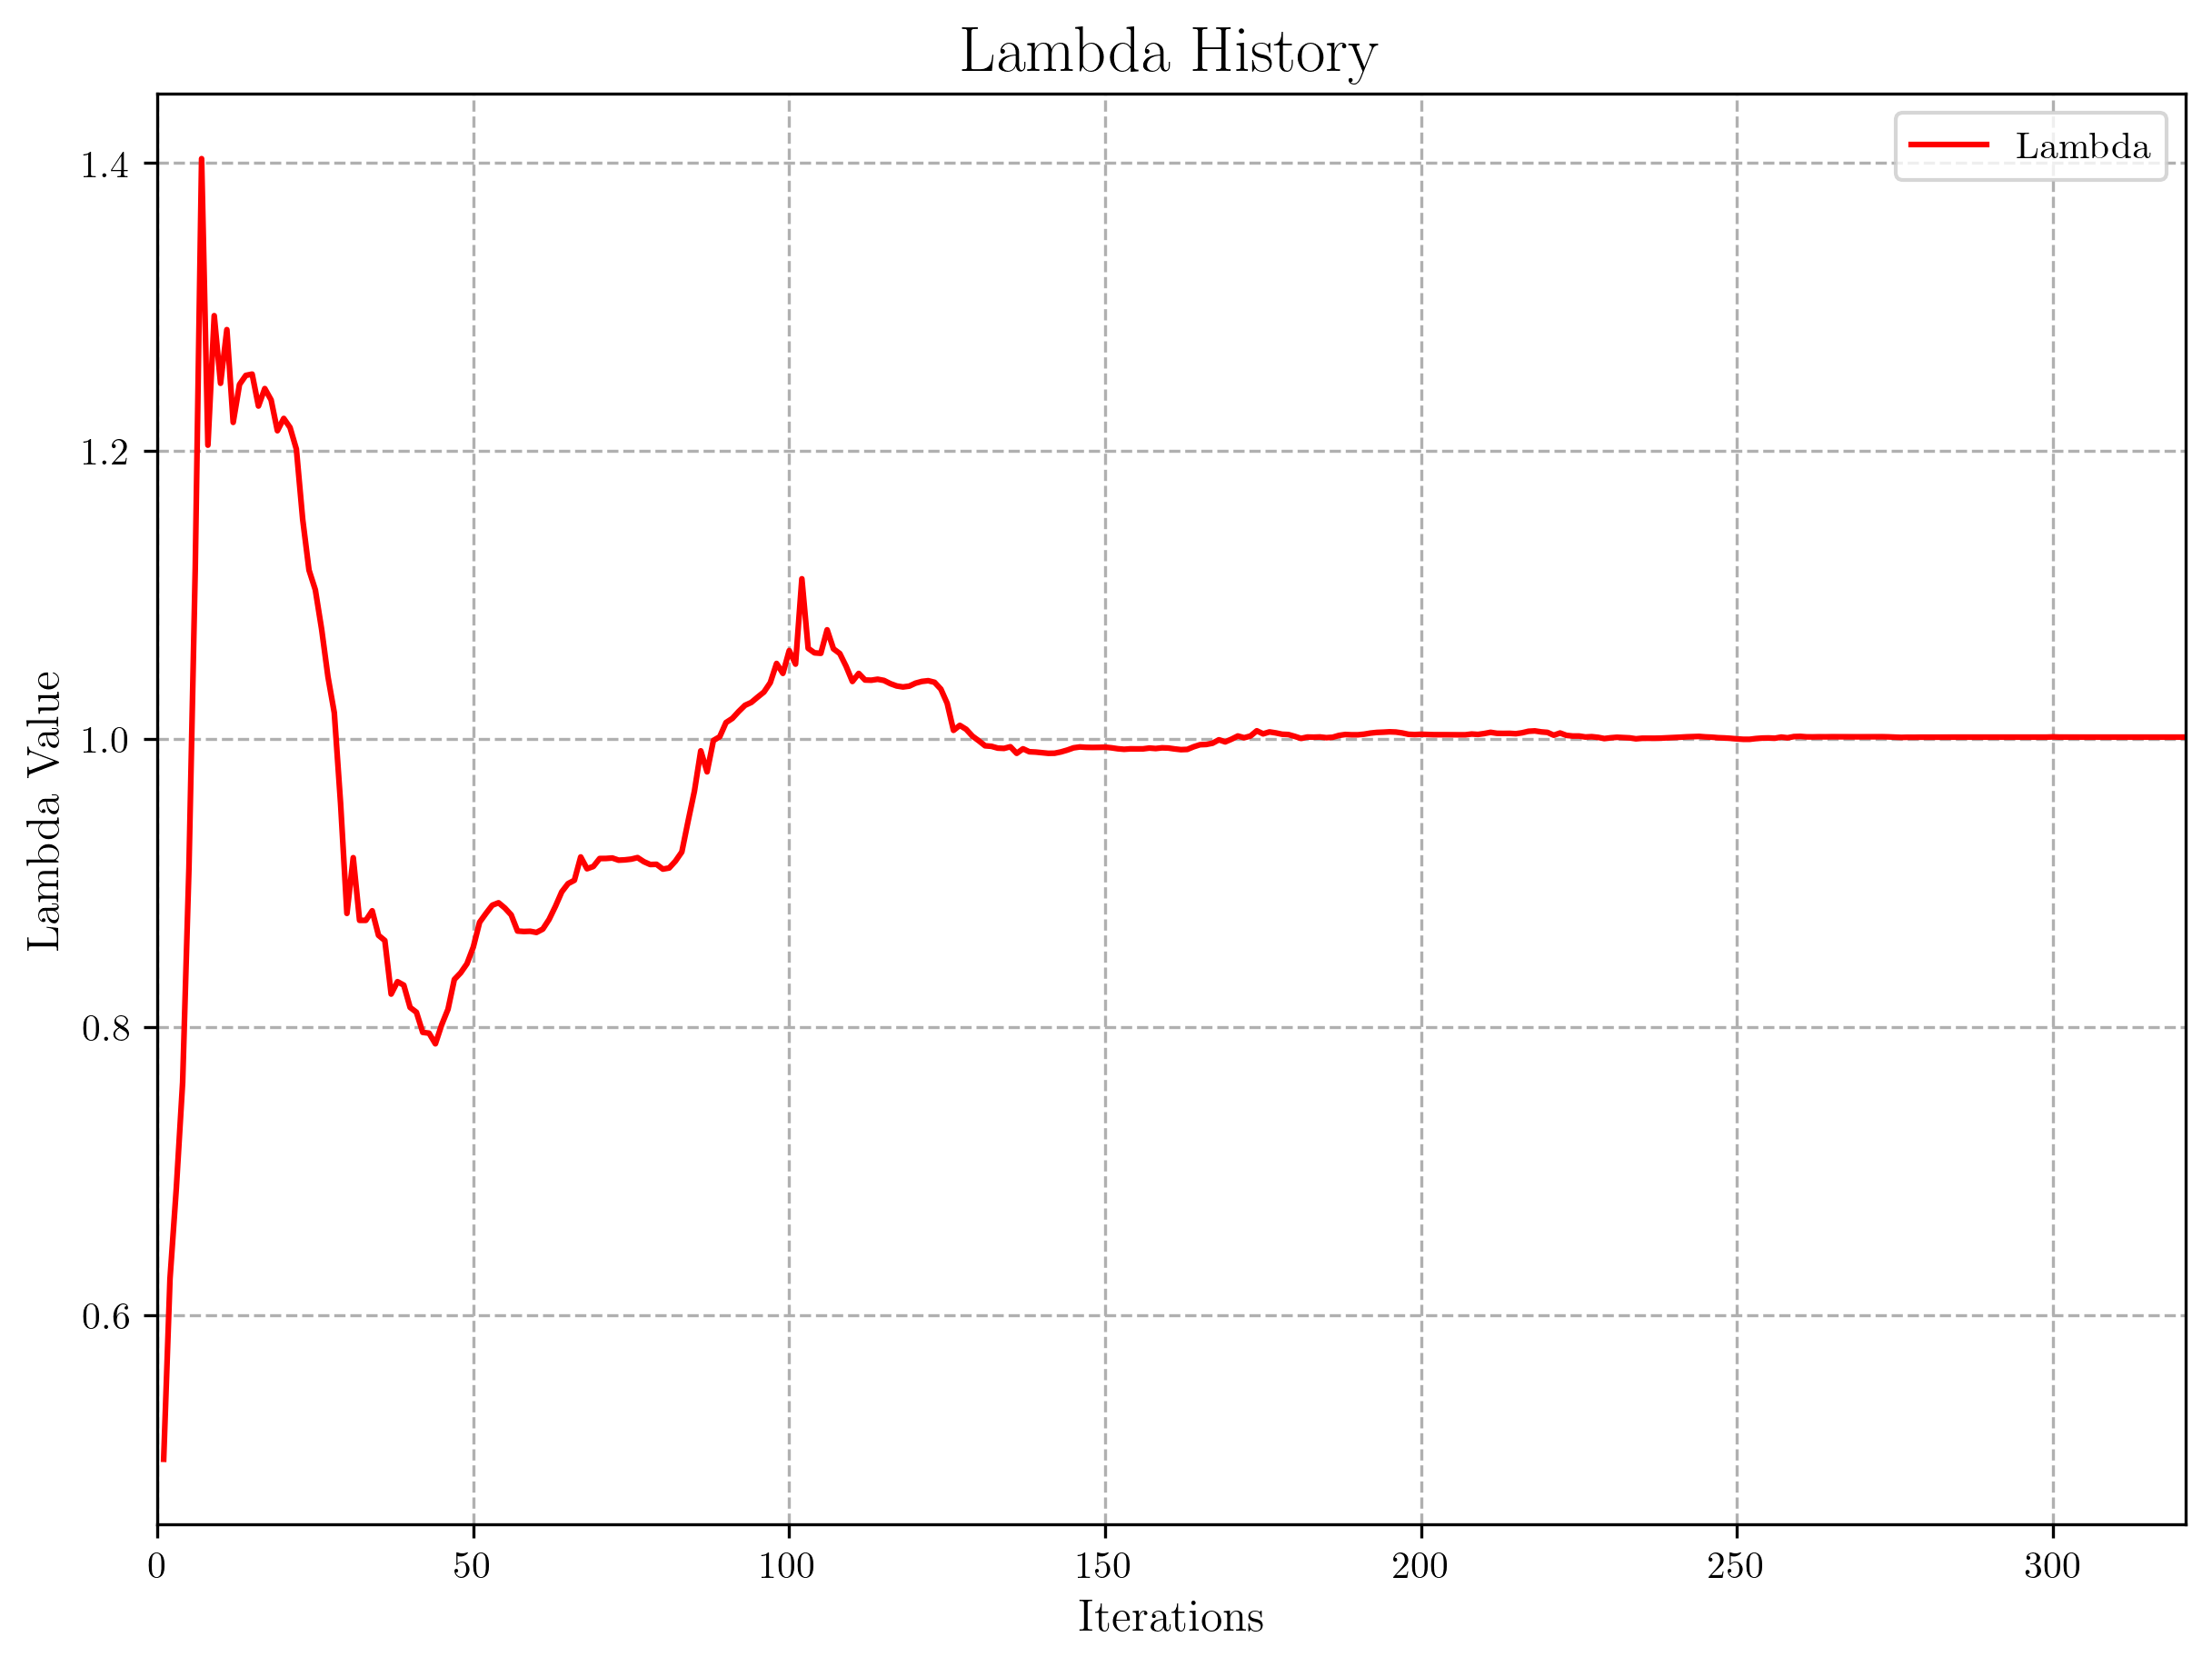

In [53]:
lambda_log = np.array(model.lambda_1_log)[:,0]
x1 = np.linspace(1, len(lambda_log), len(lambda_log))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), constrained_layout=True, dpi=300)
ax.plot(x1, lambda_log, "r", linestyle="solid", label="Lambda")

ax.set_xlim(0, x1[-1])
ax.set_xlabel("Iterations", fontsize=12)
ax.set_ylabel("Lambda Value", fontsize=12)
ax.grid(linestyle="--")
ax.legend(fontsize=10)
ax.set_title('Lambda History', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=10)

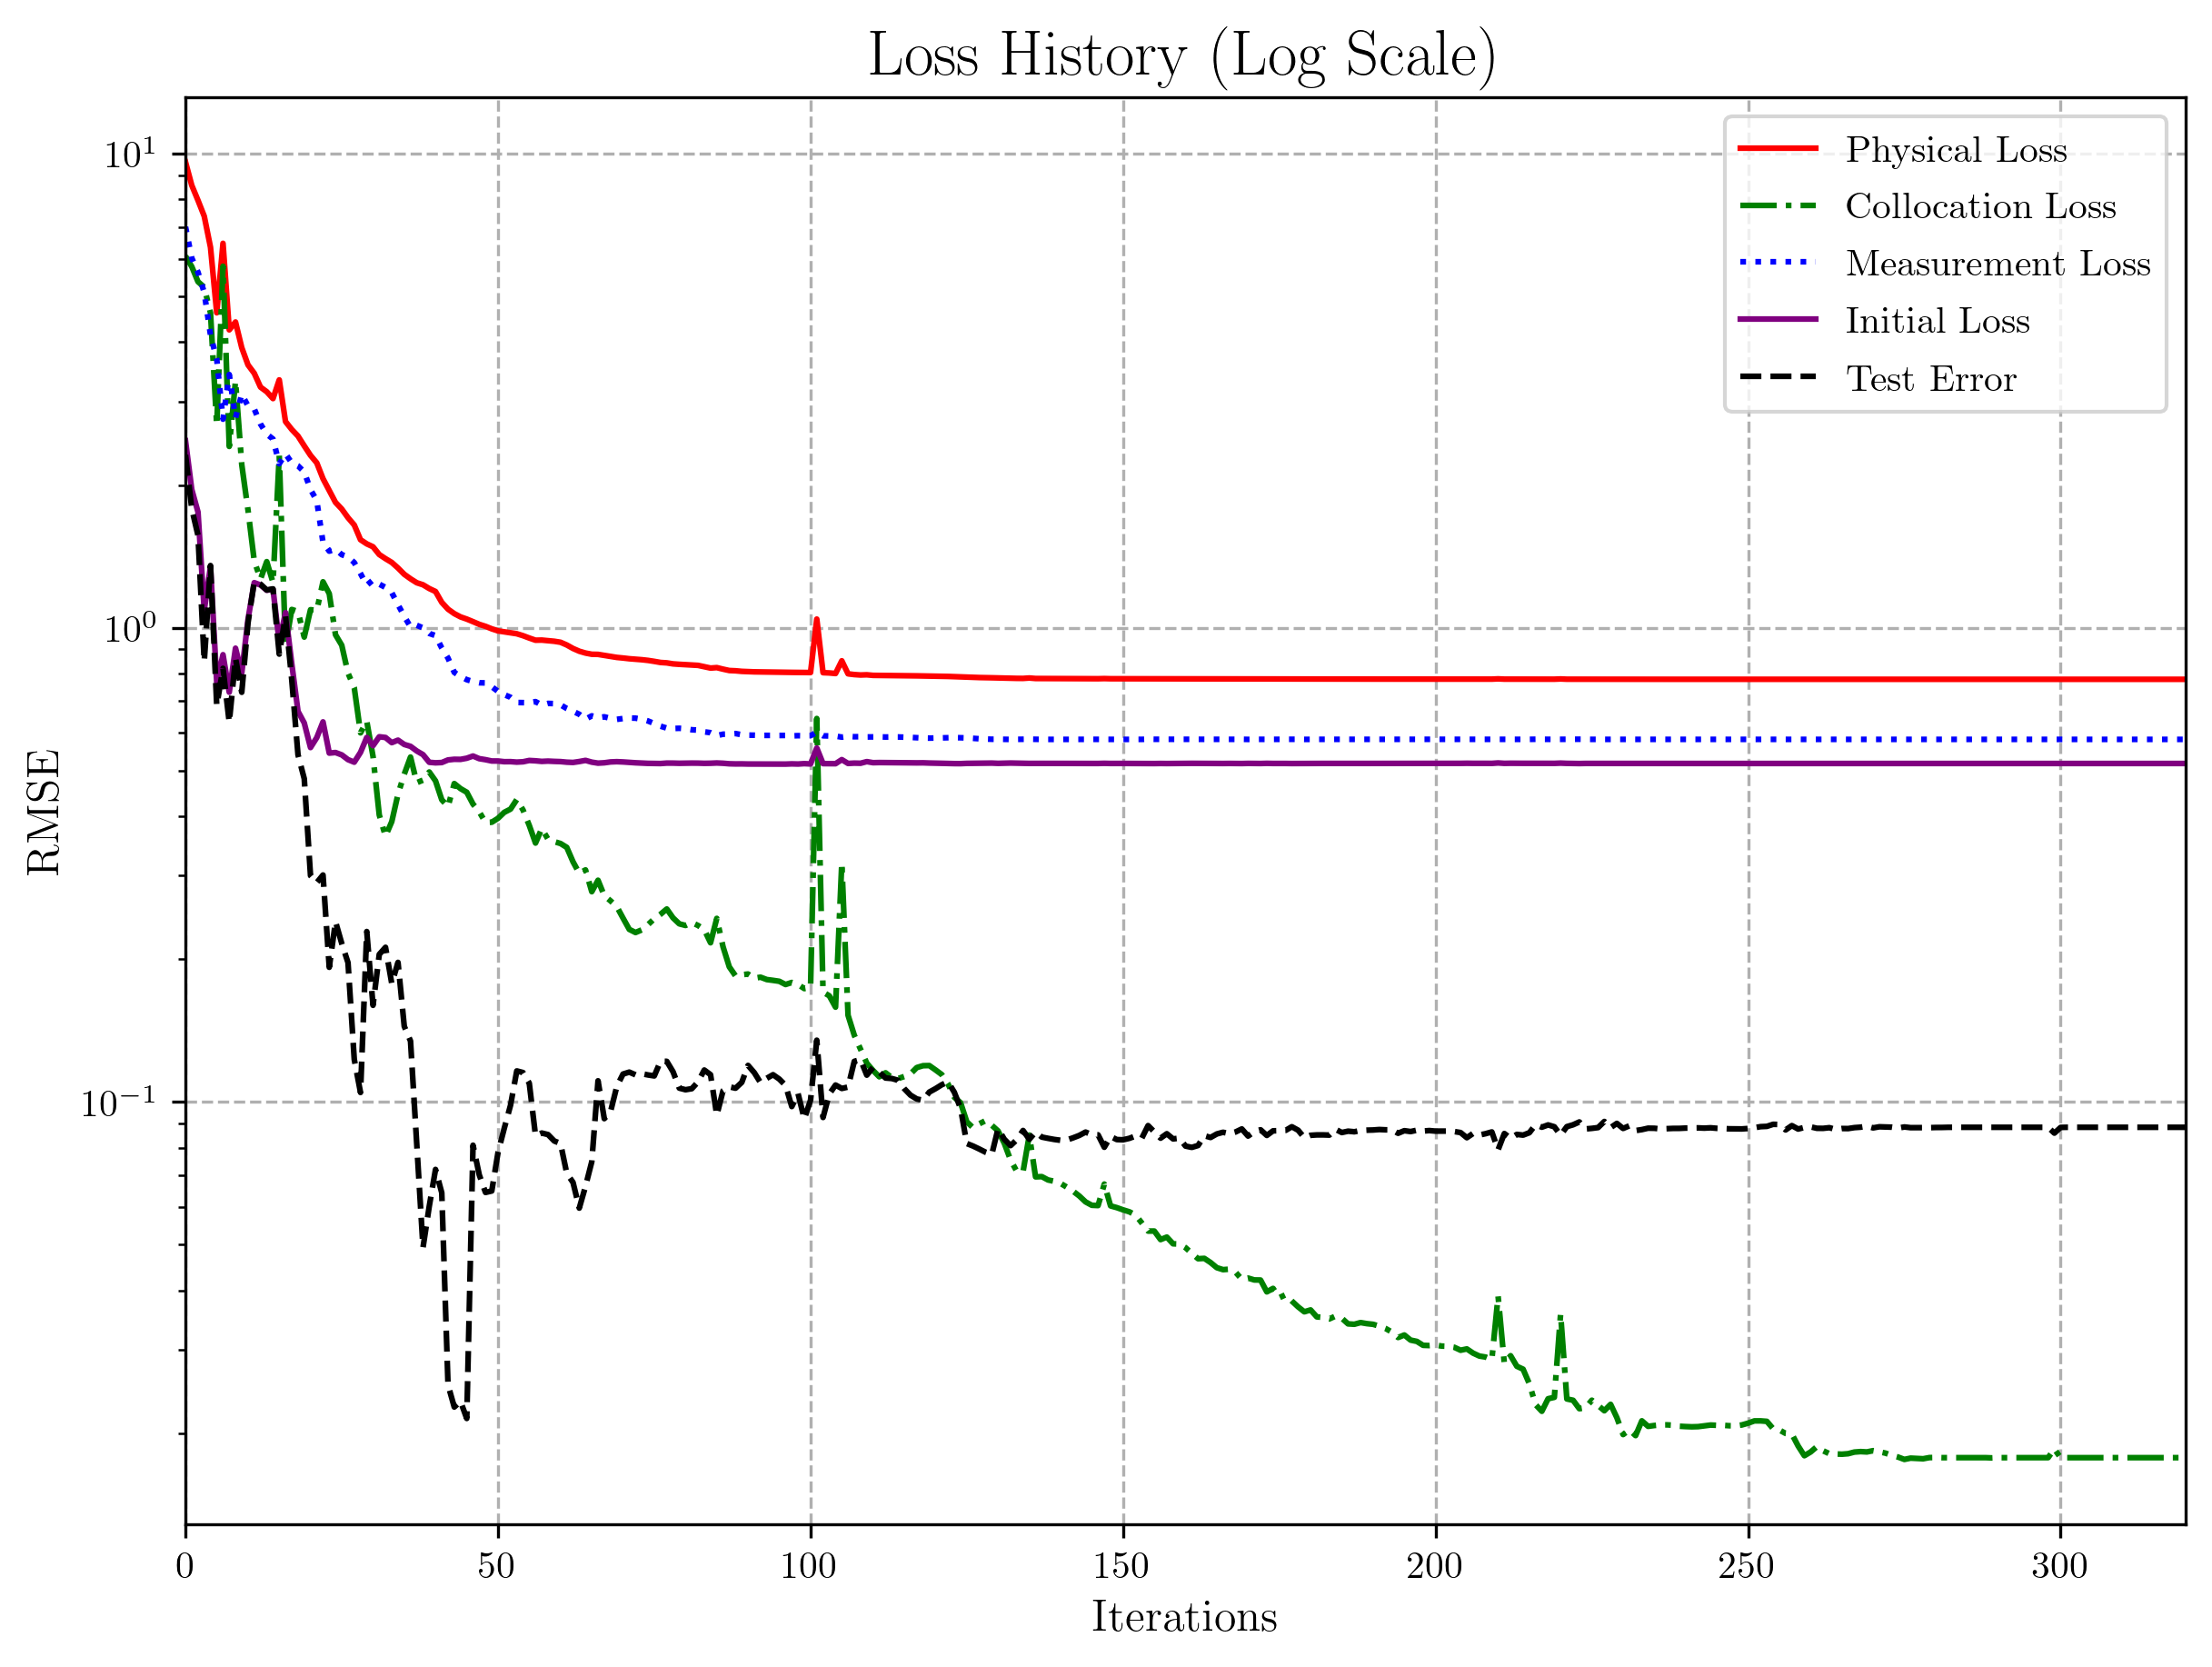

- Last Iterations: 320
- Relative Error Lambda (%): 0.131893
- Absolute Error: 0.069755
- Relative Error (%): 1.958150


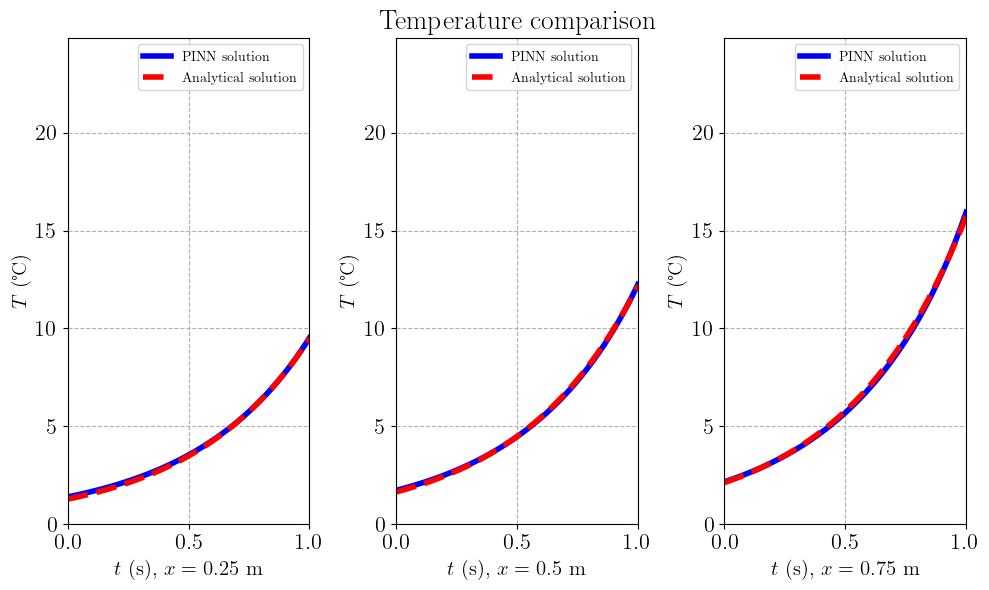

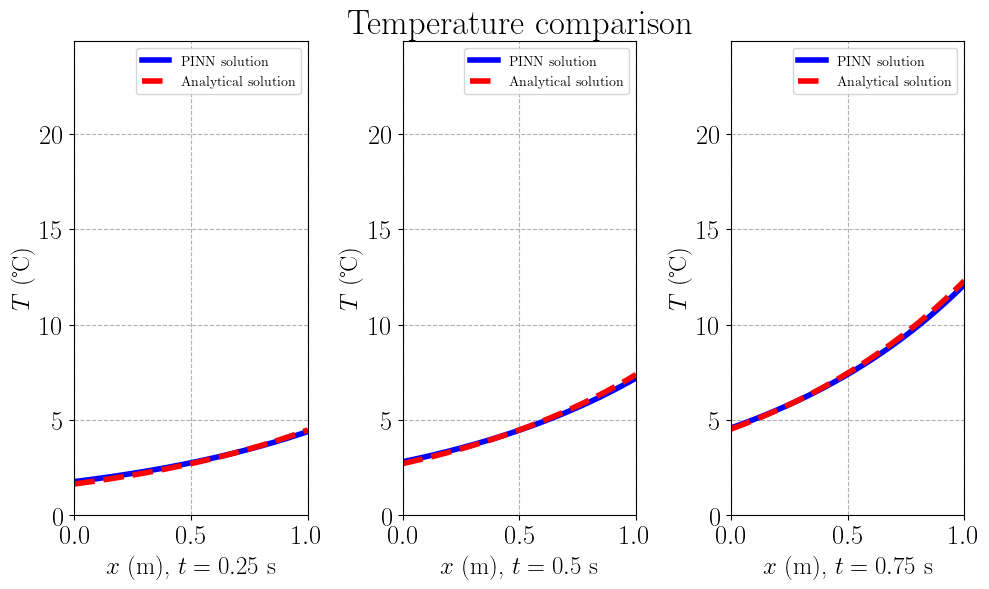

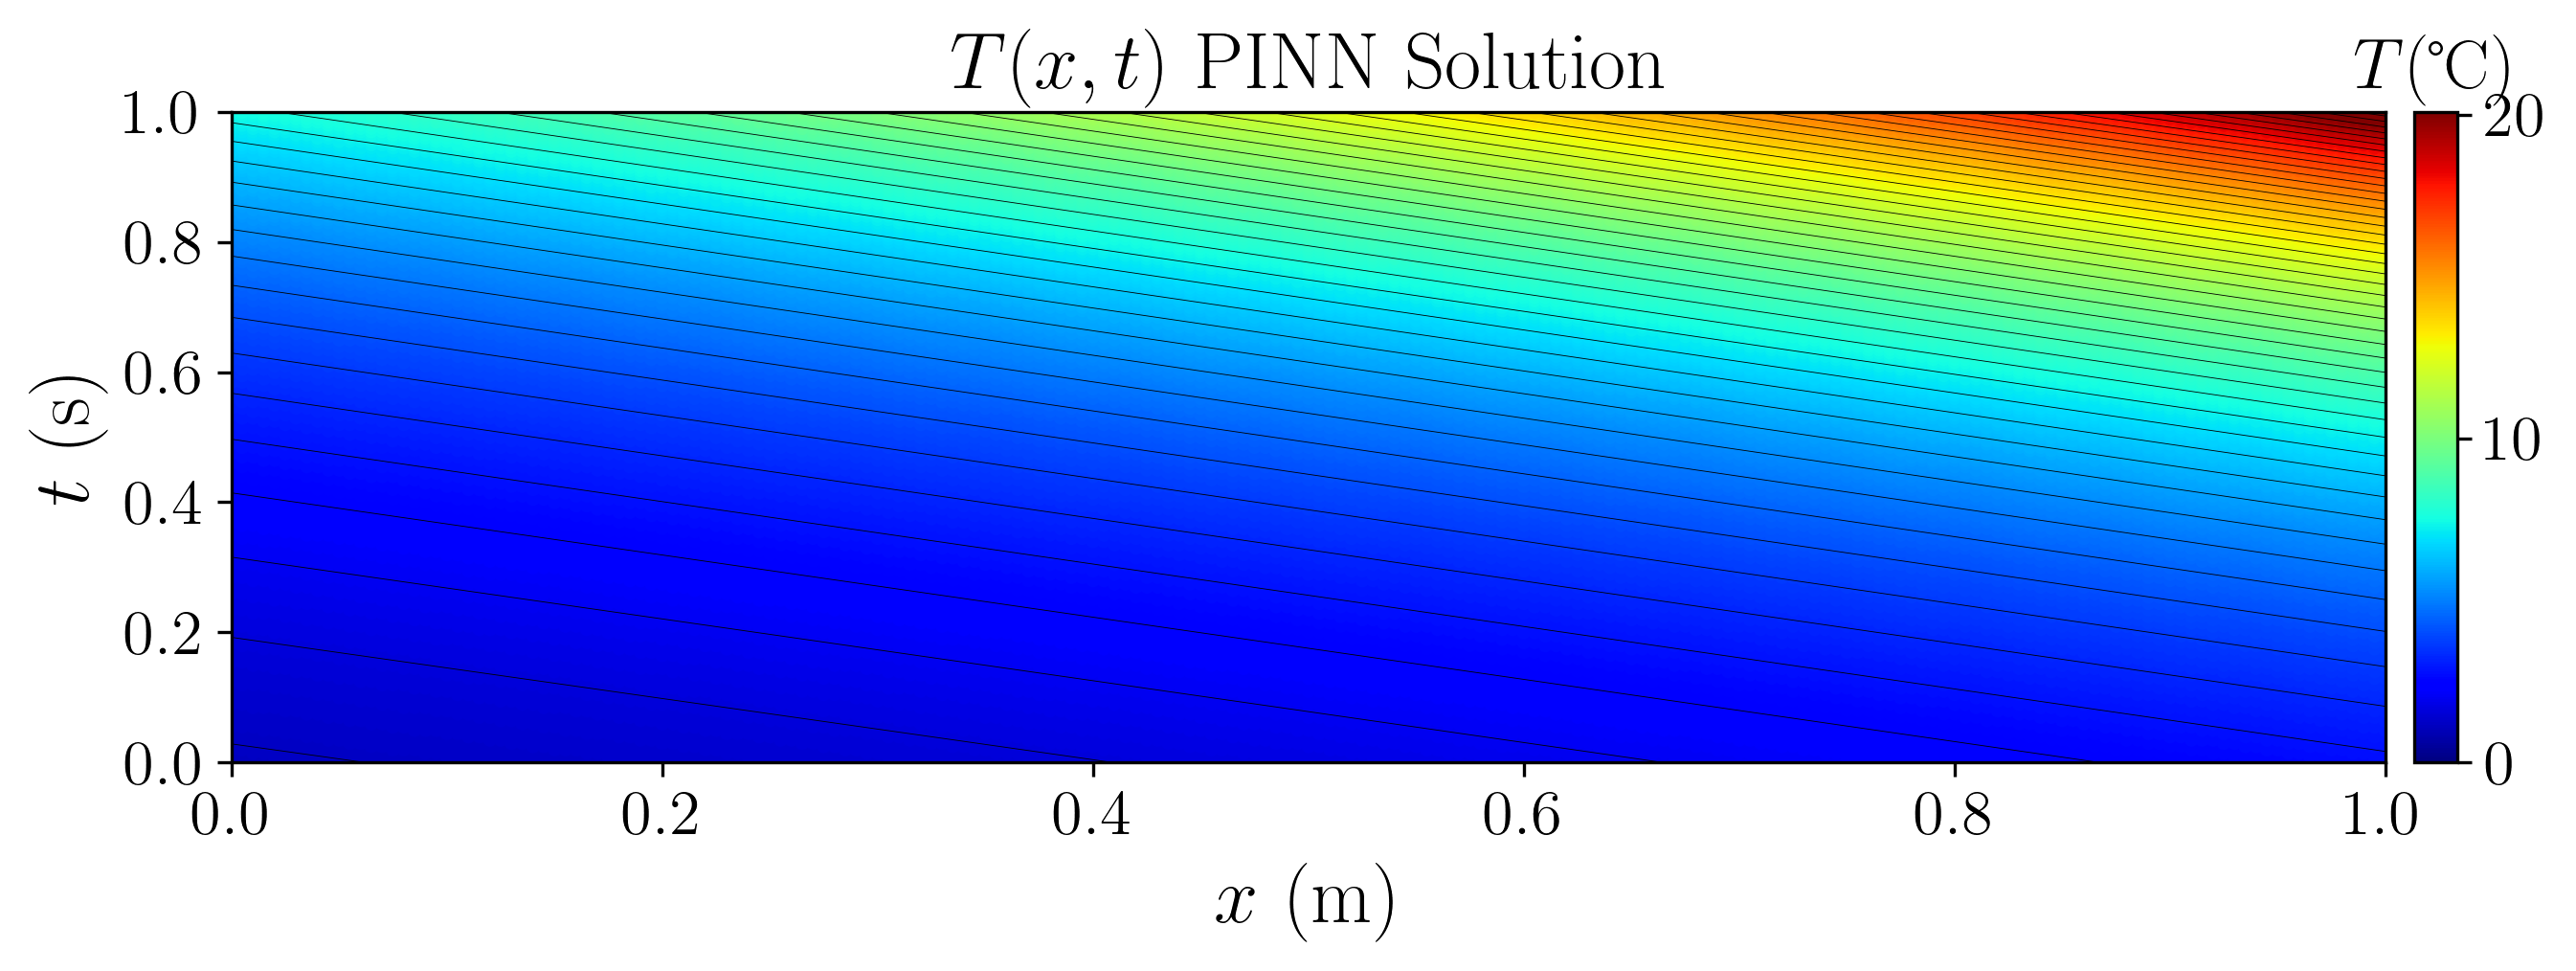

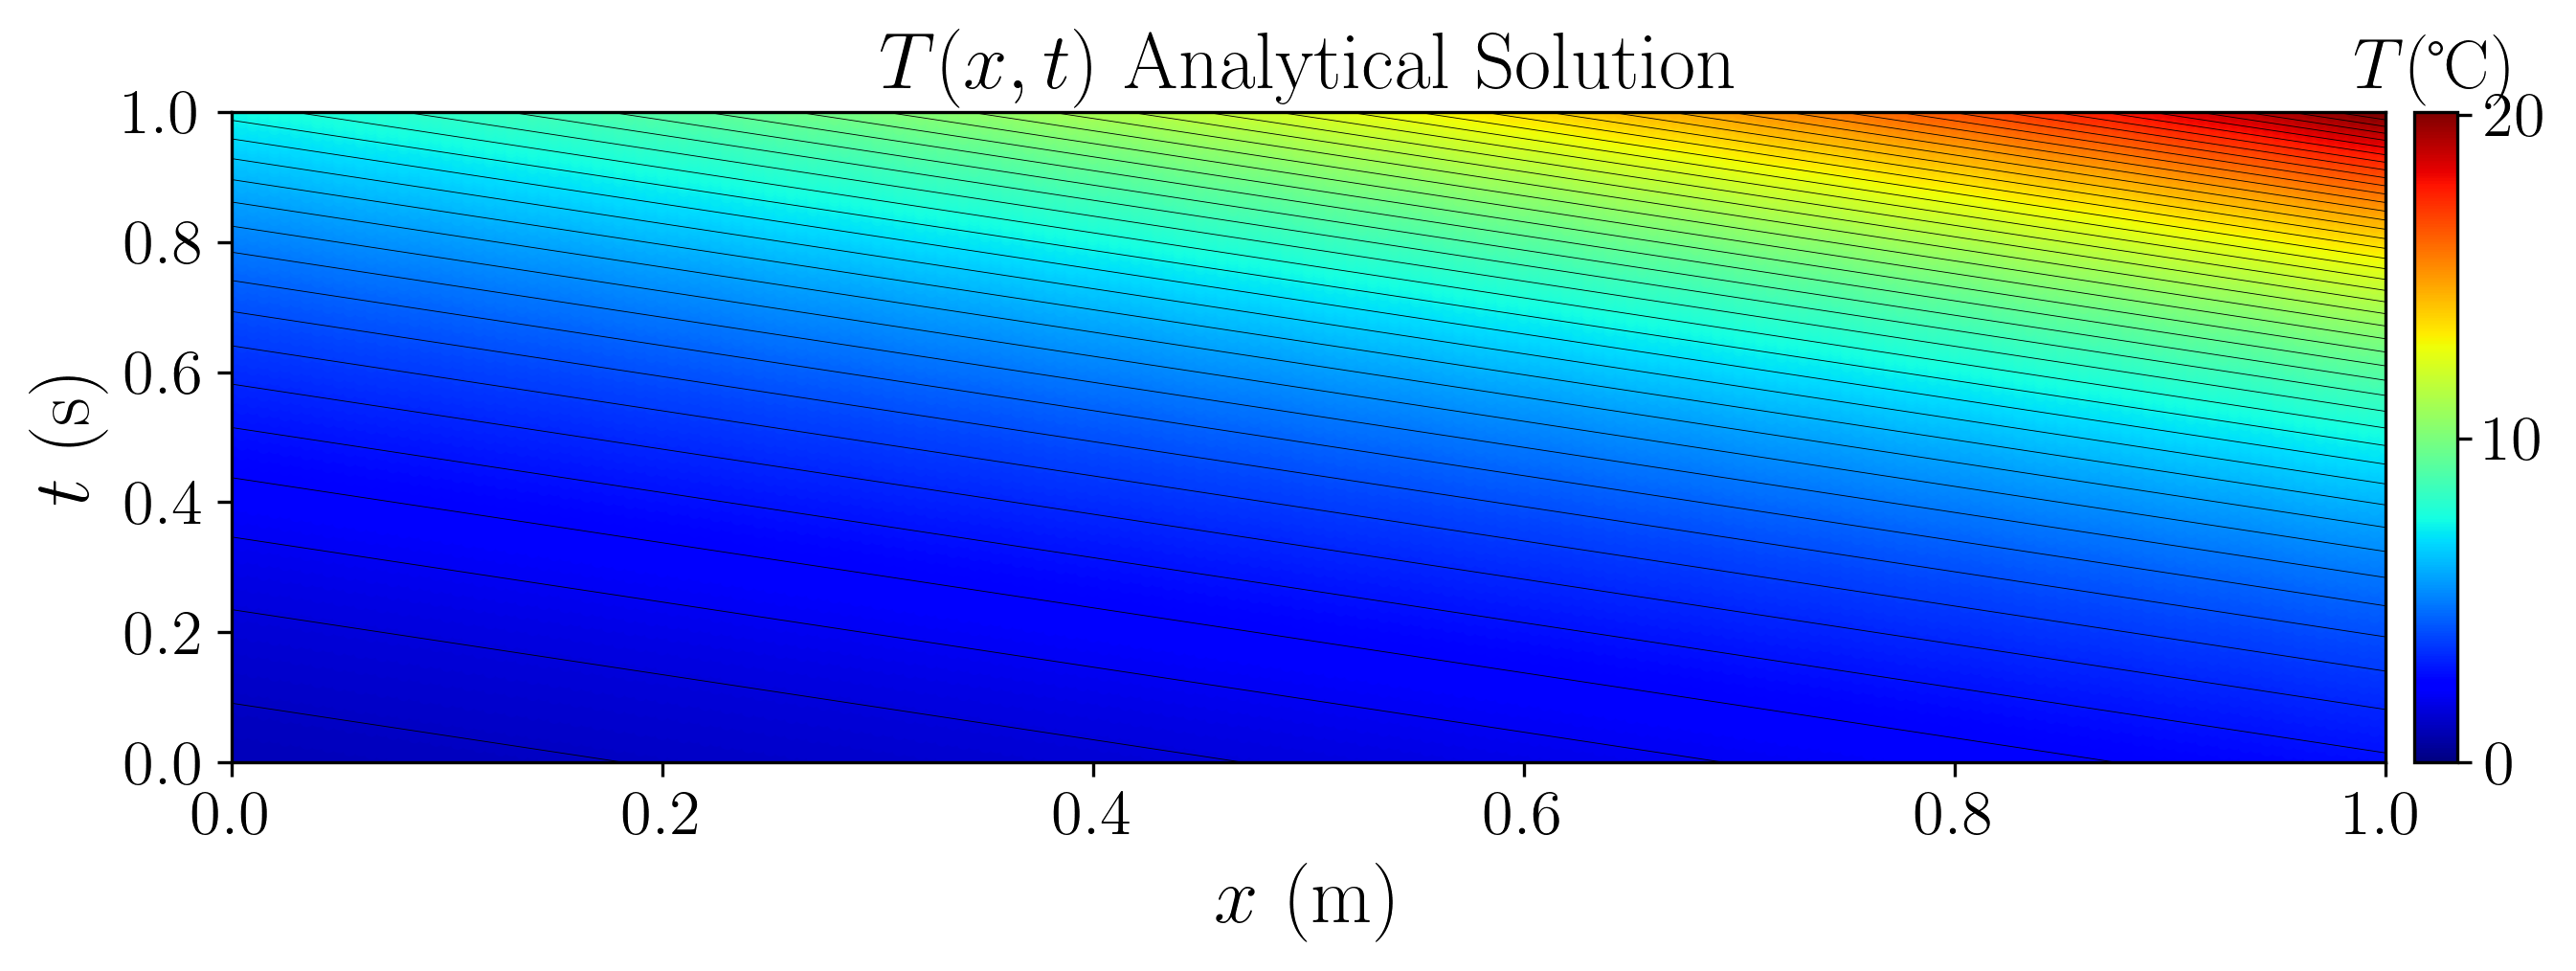

In [54]:
# Create Results
results = PostProcessing(model=model,
                      params=params,
                      save_fig=False)

results.display_loss()
results.display_contour()

In [ ]:
# Save model
model.save_model('1_inverse_param.pickle')